##### 설정

In [1]:
import sys

assert sys.version_info >= (3, 7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib 

matplotlib.rc('font', family='AppleGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

8장에서 알아본 차원 축소는 가장 널리 사용되는 비지도 학습이다. 이 장에서는 추가적인 비지도 학습 알고리즘을 알아보자.   
1. 군집: 비슷한 샘플을 클러스터로 모은다.
    - 데이터 분석, 고객 분류, 추천 시스템, 검색 엔진, 이미지 분할, 준지도 학습, 차원 축소 등에 사용
2. 이상치 탐지: '정상'데이터가 어떻게 보이는지 학습하고, 비정상 샘플을 탐지하는데 사용.
    - 제조 라인에서 결함 제품 감지, 시계열 데이터에서 새로운 트랜드 발견에 사용
3. 밀도 추정: The random process that generated the dataset의 확률 밀도 함수(PDF, probability density function)을 추정한다.
    - 이상치 탐지에 널리 사용된다. 밀도가 낮은 영역에 놓인 샘플이 이상치일 사능성이 높다.
    - 데이터 분석과 시각화에 유용하다.
    
# 1. 군집(Clustering Algorithms): k-means and DBSCAN
## 1) K-means
: 각 클러스터에 중심을 찾고 가장 가까운 클러스터에 샘플을 할당한다.   
- k-means를 실해하기 전에 입력 특성의 스케일을 맞추는 것이 중요하다.
### Hard clustering
⬇︎ blob dataset에 K-means 훈련
- Kmeans의 객체는 훈련된 샘플의 레이블을 보존 -> 샘플의 레이블이란, 샘플이 할당된 클러스터의 예측한 인덱스
- 샘플을 클러스터에 할당할 때 centroid까지 거리를 고려하는 것이 전부이기 때문에, 클러스터의 크기가 크면 알고리즘이 잘 작동하지 않는다.

In [2]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import warnings
warnings.filterwarnings('ignore')

blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                 random_state=7)
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

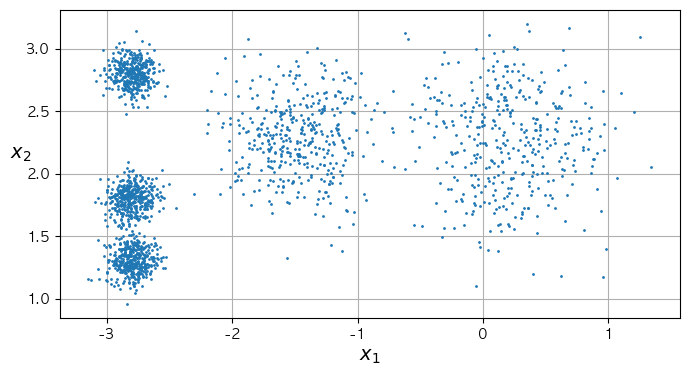

In [3]:
import matplotlib.pyplot as plt
def plot_cluster(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)
    
plt.figure(figsize=(8, 4)) 
plot_cluster(X)
plt.gca().set_axisbelow(True)
plt.grid()
plt.show()

In [4]:
#  각 샘플들이 클러스터에 할당됨
print(len(y_pred))
print("각 샘플의 클러스터 레이블 예측:", y_pred[:10])
print("y_pred is kmeans.labels_ :", y_pred is kmeans.labels_)

2000
각 샘플의 클러스터 레이블 예측: [4 0 1 0 0 4 0 0 3 0]
y_pred is kmeans.labels_ : True


In [5]:
# 5 개의 클러스터 중심 추정
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [6]:
# 새로운 샘플의 레이블 예측
X_new = np.array([[0,-9], [3,4], [-2, 4], [5,9]])
kmeans.predict(X_new)

array([4, 1, 2, 1], dtype=int32)

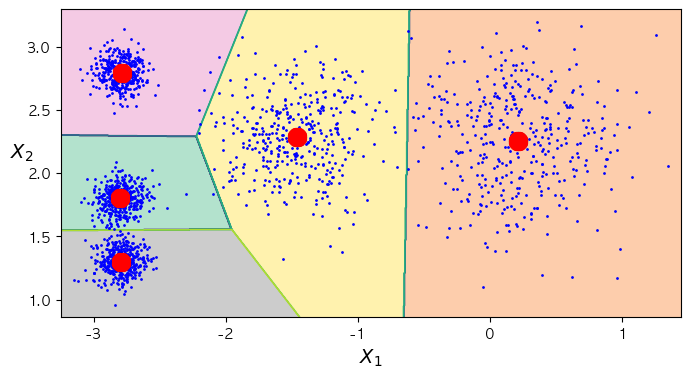

In [7]:
# 모델의 결정 경계 plot
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], "b.", markersize = 2)
    
def plot_centroides(centorids, weights=None, circle_color='k', cross_color='r'):
    if weights is not None:
        centorids = centorids[weights > weights.max() / 10]
    plt.scatter(centorids[:, 0], centorids[:, 1],
               marker='o', s=35, linewidths=8,
               color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centorids[:, 0], centorids[:, 1],
               marker='X', s=35, linewidths=8,
               color=cross_color, zorder=11, alpha=1)
    
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                            show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, color='k')
    plot_data(X)
    if show_centroids:
        plot_centroides(clusterer.cluster_centers_)
    if show_xlabels:
        plt.xlabel("$X_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$X_2$", rotation=0)
    else:
        plt.tick_params(labelbottom=False)
        
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

### Soft clustering
: 클러스터마다 샘플에 점수를 부여하는 것. 이때 점수는 샘플과 centroid 사이의 거리. 또는 similarity score가 될 수 있다.
- 샘플을 하나의 클러스터에 할당하는 hard clustering 보다 유용
- `Kmeans`클래스의 `transform()` 메서드는 샘플과 각 centroid 사이의 거리를 반환

In [8]:
X_new

array([[ 0, -9],
       [ 3,  4],
       [-2,  4],
       [ 5,  9]])

In [9]:
print(kmeans.transform(X_new))
kmeans.predict(X_new) # centroid와 샘플의 거리가 가장 가까운 인덱스 반환

[[11.15918111 11.25744923 12.12252495 11.38077234 10.67469519]
 [ 6.20644988  3.29154026  5.91661671  4.78440844  6.39764869]
 [ 2.34116605  2.81458129  1.44129201  1.79516152  2.81534093]
 [10.61714673  8.27309201  9.96061541  9.32197474 10.96007107]]


array([4, 1, 2, 1], dtype=int32)

### k-means 알고리즘 작동 방식
<img src="./images/kmeans_algorithm_plot.PNG" width="600" height="300"><br>
1. Centroid 랜덤하게 초기화: 무작위로 k개의 샘플을 뽑아 그 위치를 Centroid로 정한다.   
     → k-means는 초기화 단계에서 기본적으로 다른 Centroid와 거리가 먼 centroid를 선택함.
2. 샘플에 레이블을 할당하고 centroid를 업데이트 한다. centroid에 변화가 없을 때까지 레이블 할당과 centroid 업데이트를 반복한다.
- 이 알고리즘은 제한된 횟수 안에 수렴하는 것을 보장한다. 무한하게 반복되지 않는다. k-means는 가장 빠른 clustering 알고리즘 중 하나이다.
- 알고리즘이 수렴하는 것은 보장하지만 적절한 솔루션으로 수렴하지 못할 수 있다. (local optimum으로 수렴)
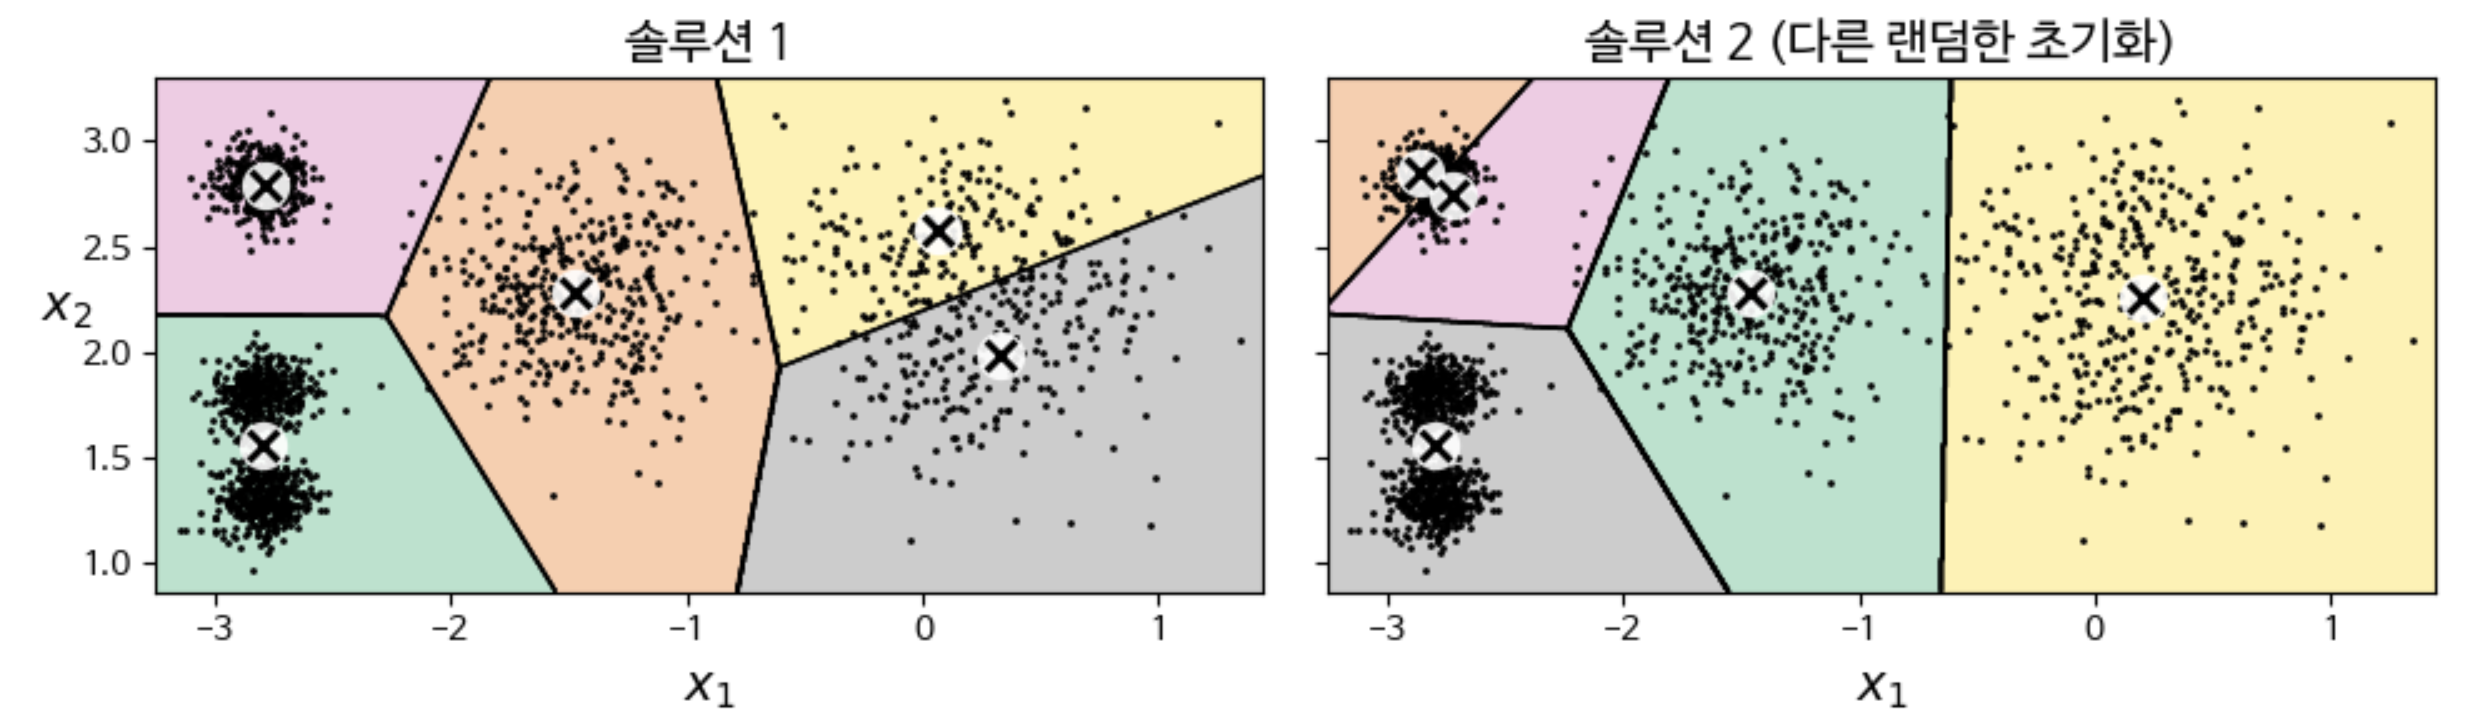<br>
**→ Centroid 초기화 방법을 개선하여 해결 가능!**
### Centroid 초기화 방법
**[방법 1] 다른 군집 알고리즘을 사용하여 근사한 centroid 위치를 알고 있는 경우**   
: init 매개변수에 centroid 리스트를 담은 넘파이 배열을 할당하고 n_init=1(초기화 횟수)로 한다.

In [10]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=10, random_state=42)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=10, random_state=42)

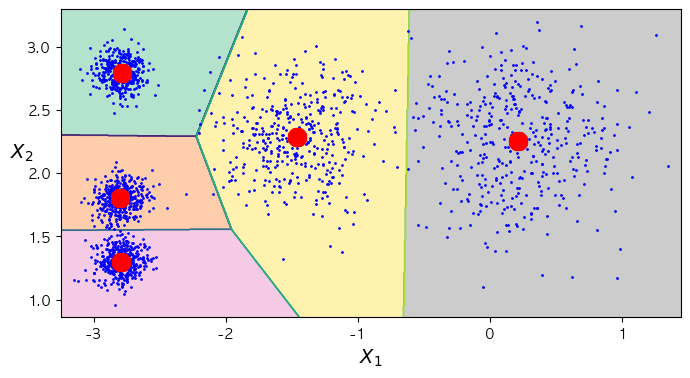

In [11]:
plt.figure(figsize=(8,4))
plot_decision_boundaries(kmeans, X)

**[방법 2] 랜덤 초기화를 다르게 하여 여러 번 알고리즘을 실행하고 가장 좋은 솔루션 선택**   
- 랜덤 초기화 n_init의 기본값은 10이다. 즉, fit() 메서드를 호출할 때 전체 알고리즘이 10번 실행된다는 의미이다. sklearn은 이 중에서 최선의 솔루션을 반환한다.
- k-means는 초기화 단계에서 기본적으로 다른 Centroid와 거리가 먼 centroid를 선택함.

### 최적의 모델을 선택하기 위한 평가 지표 : inertia(이너셔)
: Clustering은 비지도 학습이기 때문에 target이 없다. 하지만 centroid와 샘플과의 거리는 측정할 수 있다. 
- kmeans 클래스는 알고리즘을 n_init번 실행하여 inertia가 가장 낮은 모델을 반환한다.
- intertia_ 인스턴스 변수로 모델의 이너셔를 확인할 수 있다.
- score() 메서드는 inertia의 음수 값을 반환한다. 
    - score() 메서드는 sklearn의 '큰 값이 좋은 것이다.'라는 규칙을 따라야하기 때문에 음수로 반환됨.

In [12]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, random_state=9)
kmeans_rnd_init1.fit(X)
kmeans_rnd_init2.fit(X)

print(kmeans.inertia_, kmeans.score(X))
print(kmeans_rnd_init1.inertia_)
print(kmeans_rnd_init2.inertia_)

211.5985372581684 -211.5985372581684
219.43539442771404
258.6472472896164


### Mini Batch K-means
: 전체 데이터셋을 사용해 반복하지 않고 각 반복마다 미니배치를 사용해 Centroid를 조금씩 이동한다. 
- 속도 : mini batch k-means(훨씬 빠름) >>> 일반적인 k-means
- inertia : mini batch k-means(일반적으로 조금 더 나쁨) < 일반적인 k-means

In [13]:
from sklearn.cluster import MiniBatchKMeans

miniabtch_means = MiniBatchKMeans(n_clusters=5, random_state=42)
miniabtch_means.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

`memmap`과 함께 `MiniBatchKMeans` 사용하기   
: 데이터셋이 메모리에 맞지 않은 경우 가장 간단한 옵션은 IPCA에서와 같이 memmap을 사용하는 것이다.   
⬇︎ MNIST dataset으로 실습

In [14]:
# load dataset
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [15]:
# train_test split
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

# training set을 memmap에 저장
filename = "my_mnist.mmap"
X_memmap = np.memmap(filename, dtype='float32', mode='write',
                    shape=X_train.shape)
X_memmap[:] = X_train
X_memmap.flush()

In [16]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10,
                                  random_state=42)
minibatch_kmeans.fit(X_memmap)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

MiniBatch k-means VS K-means : inertia 비율과 훈련 시간 비율 비교

100/100

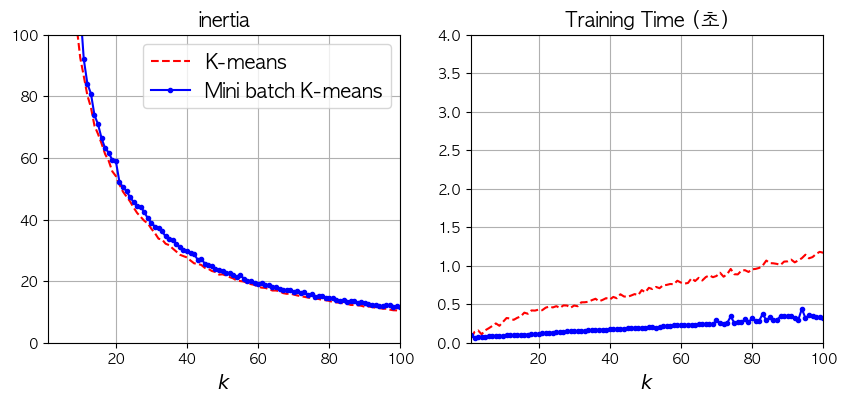

In [17]:
from timeit import timeit

max_k = 100
times = np.empty((max_k, 2))
inertias = np.empty((max_k, 2))
for k in range(1, max_k + 1):
    # 사이킷런 1.3에서 'full'이 deprecated 된다는 경고를 피하기 위해 'lloyd'로 지정함
    kmeans_ = KMeans(n_clusters=k, algorithm="lloyd", random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print(f"\r{k}/{max_k}", end="")  # \r returns to the start of line
    times[k - 1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k - 1, 1] = timeit("minibatch_kmeans.fit(X)", number=10,
                             globals=globals())
    inertias[k - 1, 0] = kmeans_.inertia_
    inertias[k - 1, 1] = minibatch_kmeans.inertia_

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, max_k + 1), inertias[:, 0], "r--", label="K-means")
plt.plot(range(1, max_k + 1), inertias[:, 1], "b.-", label="Mini batch K-means")
plt.xlabel("$k$")
plt.title("inertia")
plt.legend()
plt.axis([1, max_k, 0, 100])
plt.grid()

plt.subplot(122)
plt.plot(range(1, max_k + 1), times[:, 0], "r--", label="K-means")
plt.plot(range(1, max_k + 1), times[:, 1], "b.-", label="Mini batch K-means")
plt.xlabel("$k$")
plt.title("Training Time (초)")
plt.axis([1, max_k, 0, 4])
plt.grid()

plt.show()

### 최적의 클러스터 수(k) 찾기
: 가장 작은 inertia를 가진 모델을 선택하면 되지 않을까? Nope.
- inertia는 k가 증가함에 따라 점점 작아지기 때문에 좋은 성능 지표가 아니다. 클러스터가 늘어날 수록 각 샘플은 가까운 centroid에 더 가깝게 된다. 따라서 inertia는 더 작아질 것이다.

#### → 실루엣 점수(Silhouette Score)
: 모든 샘플에 대한 실루엣 계수(Silhouette coefficient)의 평균
- 샘플의 실루엣 계수 : $(b-a) / max(a, b)$
- a : 클러스터 내부의 평균 거리. 동일한 클러스터에 있는 다른 샘플까지 평균 거리이다.
- b : 가장 가까운 클러스터의 샘플까지의 평균 거리. 샘플과 가장 가까운 클러스터는 자신이 속한 클러스터를 제외한 b가 최소인 클러스터이다.
- 실루엣 계수는 -1 ~ +1 까지 바뀔 수 있다. 
- +1에 가까우면 자신의 클러스터에 잘 속해있고 다른 클러스터와는 멀리 떨어져 있다는 것이다.
- 실루엣 계수가 0에 가까우면 클러스터 경게에 위치한다는 의미이고 -1에 가까우면 잘못된 클러스터에 할당된 것이다.
- sklearn의 `silhouette_score()` 함수를 사용한다.

In [18]:
from sklearn.metrics import silhouette_score

In [19]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [20]:
silhouette_score(X, minibatch_kmeans.labels_)

0.3275255638676998

클러스터 개수를 다르게 하여 실루엣 점수 비교

In [21]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]

silhouette_scores = [silhouette_score(X, model.labels_)
                    for model in kmeans_per_k[1:]]

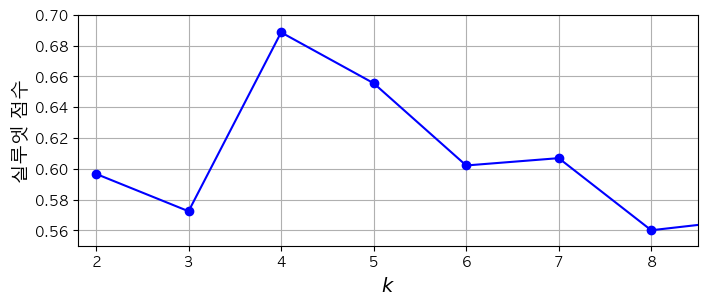

In [22]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("실루엣 점수")
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.grid()

plt.show()

### k-means의 한계
- 번거로운 작업
    - 최적의 솔루션을 위해 알고리즘을 여러 번 실행해야 한다.
    - 클러스터 개수를 지정해야 한다.
- 클러스터의 크기나 밀집도가 서로 다르거나 원형이 아닐 경우 잘 작동하지 않는다. 아래 그림을 보면 k-means이 크기와 밀집도, 방향이 다른 세 개의 타원형 클러스터를 가진 데이터셋의 클러스터를 적절히 구분하지 못한다.

**이러한 타원형 클러스터에서는 가우시안 혼합 모델이 잘 작동한다.**

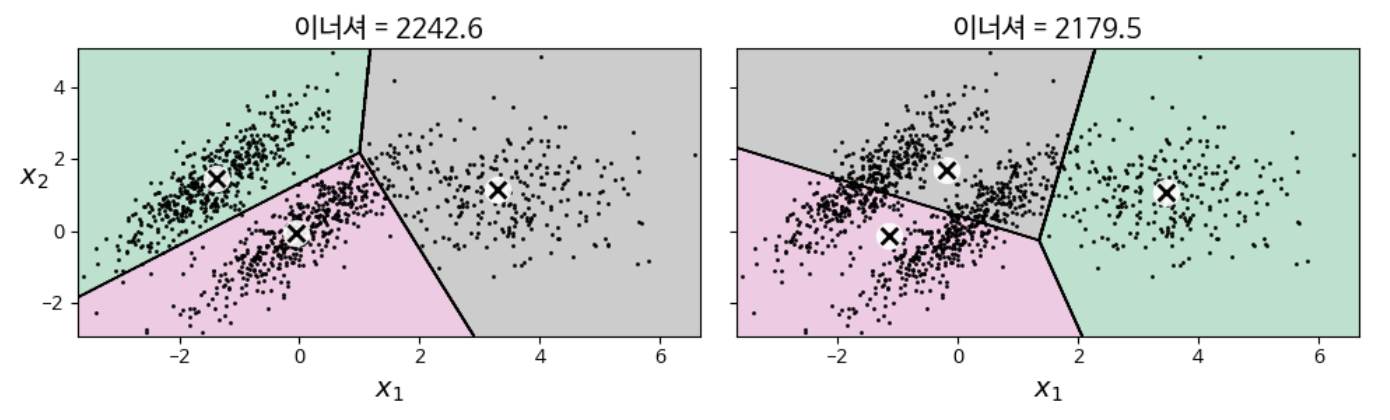

In [23]:
from IPython.display import Image
Image("./images/bad_kmeans_plot.png", width=500, height=300)

## 2) DBSCAN
- DBSCAN : density-based spatial clustering of applications with noise
- DBSCAN은 고밀도의 연속된 지역을 클러스터로 정의한다.
<!-- - defines clusters as continuous regions of high density. -->
- DBSCAN은 모든 클러스터가 밀집되어 있는 지역과 그렇지 않은 지역이 잘 구분될 때 성능이 좋다.    
- 장점
    1. 클러스터의 모양과 개수에 상관없이 감지할 수 있다.
    2. 사전에 클러스터의 개수를 지정할 필요 없다.(hyperprameter: eps, min_samples로 2개 밖에 없음)
    3. 이상치에 안정적이다.
- 단점
    : 클러스터 간 밀집도가 크게 다르면 모든 클러스터를 올바르게 잡아내는 것이 불가능하다.

> **알고리즘 작동방식**
> 1. 각 샘플에서 작은 거리인 ℇ(epsilon) 내에 몇 개의 샘플이 놓여있는지 카운트한다. 이 지역을 샘플의 ε-neighborhood라고 한다.
> 2. 자기 자신을 포함하여 ε-neighborhood 내에 `min_samples`개의 샘플이 있다면 이를 core instance로 간주한다.
> 3. core instance의 이웃에 있는 모든 샘플은 동일한 클러스터에 속한다. 이때 이웃에는 다른 core instance가 포함될 수 있는데, core instance의 이웃의 이웃은 계속해서 하나의 클러스터를 형성한다.
> 4. core instance도 아니고 이웃도 아닌 샘플은 이상치로 판단한다.<br>

⬇︎ make_moons dataset에서 test

In [24]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [25]:
# labels_ : 모든 샘플의 레이블 저장. -1은 이상치로 판단한 샘플
print("dbscan.labels_ : ", dbscan.labels_[:10])

# core_sample_indices_: core sample의 인덱스 반환. X에서의 인덱스 번호
print("core_sample_indices_ : ", dbscan.core_sample_indices_[:10])

# core sample 값 반환
print("components_ : ")
dbscan.components_[:10]

dbscan.labels_ :  [ 0  2 -1 -1  1  0  0  0  2  5]
core_sample_indices_ :  [ 0  4  5  6  7  8 10 11 12 13]
components_ : 


array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       [ 0.29248724, -0.20696309],
       [-0.02637836,  0.44766267],
       [ 1.6201408 , -0.28758856],
       [ 1.26718285, -0.40793471],
       [ 0.87418608,  0.50781041],
       [ 0.3322007 , -0.19032202],
       [ 1.952812  ,  0.22552333]])

In [26]:
X[:11]

array([[-0.02137124,  0.40618608],
       [ 0.97670045, -0.45832306],
       [ 0.90405882, -0.37651952],
       [ 0.37736316, -0.39703717],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       [ 0.29248724, -0.20696309],
       [-0.02637836,  0.44766267],
       [ 1.6201408 , -0.28758856],
       [ 0.68246733,  0.80712069],
       [ 1.26718285, -0.40793471]])

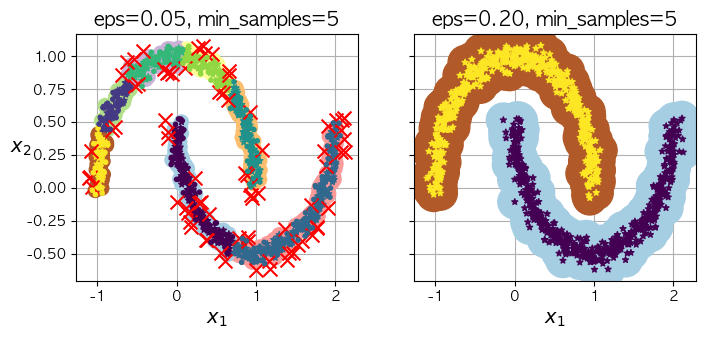

In [27]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20,
                c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1],
                c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}")
    plt.grid()
    plt.gca().set_axisbelow(True)

dbscan2 = DBSCAN(eps=0.2) # eps를 늘려 이웃의 범위를 넓힌다.
dbscan2.fit(X)

plt.figure(figsize=(8, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

eps을 0.05로 했을 때는 총 7개의 cluster가 만들어 졌다. eps을 0.2로 증가하면 샘플의 이웃 범위를 넓히면 2개의 cluster로 좋은 군집이 만들어졌다.

- DBSCAN 클래스는 predict() 메서드가 아닌 `fit_predict()`메서드만 제공한다. 즉, 이 알고리즘은 새로운 샘플에 대한 클러스터 예측은 불가능하다. 이러한 문제는 다른 분류 알고리즘이 더 잘 수행한다.<br>
⬇︎ KNeighrborsClassifier 훈련
- 아래 예시에서는 core inatance만 훈련했지만 모든 샘플에서 훈련할 수 있다. 또한 이상치를 제외할 수도 있다. 선택은 최종 성능에 따라 다르다.

In [28]:
from sklearn.neighbors import KNeighborsClassifier

# eps=0.2를 사용한 dbscna2 사용
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan2.components_, dbscan2.labels_[dbscan2.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [29]:
X_new = np.array([[-0.5, 0],[0, 0.5], [1, -0.1], [2, 1]])
print("predict(X_new): ", knn.predict(X_new))
print("predict_proba(X_new) : ")
knn.predict_proba(X_new)

predict(X_new):  [1 0 1 0]
predict_proba(X_new) : 


array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

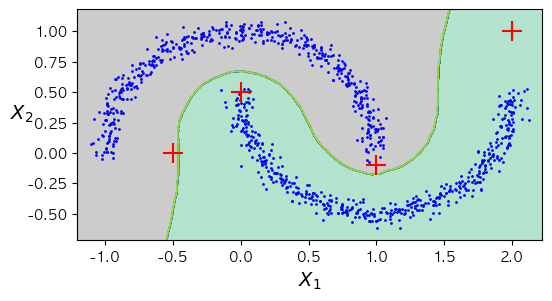

In [36]:
plt.figure(figsize=(6, 3))

plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="r", marker="+", s=200, zorder=10)

plt.show()

위의 그래프에서 **<span style="color:red">+</span>** 는 X_new이다. 훈련 셋에 이상치가 없기 때문에 클러스터가 멀리 떨어져 있어도 분류기는 1개의 클러스터를 선택한다.<br>
⬇︎ `KNeighborsClassifier`의 `kneighbors()` 메서드를 사용하면 멀리 떨어진 샘플들을 이상치로 분류할 수 있다.

In [69]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan2.labels_[dbscan2.core_sample_indices_][y_pred_idx]
print("y_dist: ", y_dist.ravel())
y_pred[y_dist > 0.2] = -1 # epsilon이 0.2보다 크면 이상치로 간주. -1로 바꿔준다.
y_pred.ravel() # -1은 이상치

y_dist:  [0.43045422 0.02225568 0.06010476 0.48399468]


array([-1,  0,  1, -1])

# 2. GMM(Gaussian Mixture Model, 가우시안 혼합모델)
: GMM은 샘플이 파라미터가 알려지지 않은 여러 개의 혼합된 가우시안 분포에서 생성되었다고 가정하는 확률모델이다. 하나의 가우시안 분포에서 생성된 모든 샘플은 하나의 클러스터를 형성하고, 이 클러스터는 일반적으로 타원형이다.
- 밀집도 추정, 군집, 이상치 탐지에 사용 가능   
- GMM은 generative model이다. 즉 이 모델에서 새로운 샘플을 만들 수 있다.
⬇︎ Scikit-Learn’s GaussianMixture class makes this super easy:

In [70]:
# (K-means이 문제를 겪었던) 앞서와 동일한 세 개의 타원형 클러스터를 가진 데이터셋을 생성
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [77]:
# Training GMM
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

**EM(Expectation-maximization, 기댓값 최대화)** 이 추정한 가중치는 [0.39 0.4  0.21]로 실제 이 데이터를 생성하기 위해 사용한 가중치 0.2, 0.4, 0.4와 매우 비슷하다.
- GaussianMixture 클래스는 EM 알고리즘을 사용한다. 이 알고리즘은 k-means와 공통점이 많다.
    1. 기댓값 단계(Expectation step): 샘플을 클러스터에 할당한다.
    2. 최대화 단계(Maximization step): 클러스터를 업데이트 한다.
    3. k-means와 같이 EM도 나쁜 솔루션으로 수렴할 수 있다. `n_init`을 설정하여 여러 번 실행 후 가장 좋은 솔루션을 선택해야 한다.(_주의: `n_init`은 default는 1_)
    > 다른점 : k-means와 달리 EM은 soft cluster 할당 사용. <br>즉 알고리즘은 기댓값 단계에서 각 클러스터에 속할 **확률**을 예측한다.  
    그 다음 최대화 단계에서 모든 샘플을 사용해 업데이트 된다.    
    클러스터에 속할 **확률**로 샘플에 가중치가 적용된다. 이 확률을 샘플에 대한 클러스터의 **responsibility**라고 한다.    
    최대화 단계에서 클러스터 업데이트는 **responsibility**가 가장 많은 샘플에 영향을 크게 받는다.

In [98]:
print("weights_ : ", gm.weights_.round(2)) # EM(Expectation-maximization, 기댓값 최대화)이 추정한 파라미터
print("means_ : \n", gm.means_)
print("covariances_ : \n", gm.covariances_.round(2))
print("알고리즘이 수렴했나요? ", gm.converged_)
print(f"몇 번의 반복이 필요했나요? {gm.n_iter_} 번")

weights_ :  [0.39 0.4  0.21]
means_ : 
 [[ 0.05131611  0.07521837]
 [-1.40763156  1.42708225]
 [ 3.39893794  1.05928897]]
covariances_ : 
 [[[ 0.69  0.8 ]
  [ 0.8   1.21]]

 [[ 0.63  0.73]
  [ 0.73  1.16]]

 [[ 1.15 -0.03]
  [-0.03  0.95]]]
알고리즘이 수렴했나요?  True
몇 번의 반복이 필요했나요? 4 번


In [99]:
# prediction
print(gm.predict(X)[:20]) # hard clustering
print(gm.predict_proba(X)[:20].round(2)) # soft clustering

[0 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 1 0 2 1]
[[0.98 0.   0.02]
 [0.98 0.   0.02]
 [0.   1.   0.  ]
 [0.99 0.   0.01]
 [0.   1.   0.  ]
 [0.01 0.99 0.  ]
 [0.99 0.   0.01]
 [0.03 0.97 0.  ]
 [0.   1.   0.  ]
 [1.   0.   0.  ]
 [0.   1.   0.  ]
 [1.   0.   0.  ]
 [0.99 0.   0.01]
 [0.95 0.   0.05]
 [1.   0.   0.  ]
 [0.99 0.   0.01]
 [0.   1.   0.  ]
 [1.   0.   0.  ]
 [0.34 0.   0.66]
 [0.   1.   0.  ]]


In [110]:
# generate new samples -> 반환된 샘플은 클러스터 인덱스 순으로 정렬되어 있음
X_new, y_new = gm.sample(6)
print("X_new : \n", X_new.round(2))
print("y_new : ", y_new)

# 주어진 위치에서 밀도 추정
print("density estimation : \n", gm.score_samples(X_new).round(2))

X_new : 
 [[-0.87 -0.33]
 [ 0.3   0.28]
 [-2.8  -0.09]
 [ 3.98  1.5 ]
 [ 3.82  0.53]
 [ 2.84 -0.74]]
y_new :  [0 0 1 2 2 2]
density estimation : 
 [-3.34 -2.03 -3.5  -3.7  -3.66 -5.31]


`gm.score_samples(X_new)`를 사용하여 그 위치의 확률 밀도 함수(PDF, Probabilty density function)의 로그를 예측한다. 점수가 높을수록 밀도가 높다. 이 점수의 지숫값을 계산하면 **샘플의 위치에서 PDF값**을 얻을 수 있다.    

이 값은 **확률 밀도**이다. 확률 밀도는 하나의 확률 값이 아니라 **확률 변수(random variable)값이 특정 범위 안에 있을 확률**을 나타낸다. 즉 어떠한 양수값도 될 수 있다. 이 값은 **확률 밀도 함수 그래프의 아래 면적이며 적분**으로 계산할 수 있다.  

다시말해 **샘플이 특정 지역 안에 속할 확률을 예측하려면 그 지역에 대해 PDF를 적분해**야 한다.(샘플 위치 전 지역에 대해 적분하면 1이 된다.)
<!-- If you compute the exponential of these scores, you get the value of the PDF at the location of the given instances. These are not probabilities, but probability densities: they can take on any positive value, not just a value between 0 and 1. -->

In [115]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full)) # 확률 밀도(지수값) :  샘플의 위치에서 PDF값
pdf_probas = pdf * (1 / resolution) ** 2 # 샘플이 특정 지역 안에 속할 확률(적분)
pdf_probas.sum() # 적분한 값을 모두 더하면(샘플 위치 전 지역에 대해 적분) == 1

0.9999999999215022

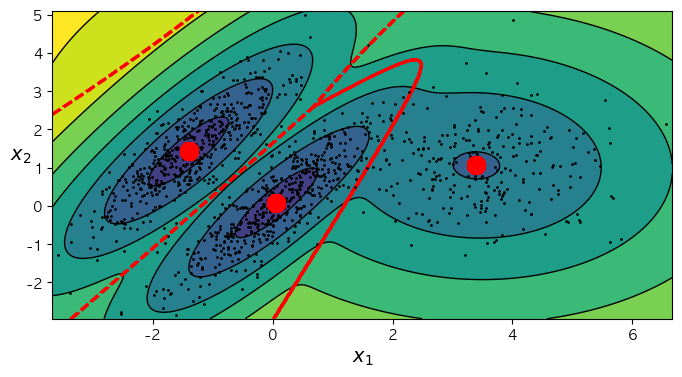

모델 gm의 클러스터 평균, 결정 경계, 밀도 등고선을 보여준다.


In [120]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroides(clusterer.means_, clusterer.weights_)
    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()
print("모델 gm의 클러스터 평균, 결정 경계, 밀도 등고선을 보여준다.")

위의 예시는 2D 가우시안 분포를 이용해 데이터를 생성한 쉬운 작업이지만, 현실 데이터는 가우시안 분포가 아니거나 고차원인 경우가 많다. 또한 이 GMM은 파라미터로 정확한 클러스터 수를 넣었다.(`n_components = 3`) feature나 cluster 수가 많거나 샘플이 적을 때에는 EM이 최적의 솔루션으로 수렴하기 어렵다. 작업의 어려움을 줄이려면 **파라미터 개수를 제한**해야 한다.
> **공분산 행렬에 제약을 추가하여 클러스터의 모양과 방향의 범위 제한**
> - sklearn에서는 `covatiance_type` 파라미터 값 설정하여 제약 가능. 기본값은 'full'이다. 즉 제약이 없는 공분산 행렬을 가지기 때문에 각 클러스터는 모양, 크기, 방향에 제약이 없다.
    - `spherical`   
        : 모든 클러스터가 원형. 지름은 다를 수 있음(분산이 다름).
    - `diag`   
        : 클러스터는 크기에 상관없이 어떤 타원형도 가능. 하지만 타원의 축은 좌표 축과 나란해야 함(공분산 행렬이 대각 행렬이어야 함).
    - `tied`   
        : 모든 클러스터가 동일한 타원 모양, 크기, 방향을 가짐(모든 클러스터는 동일한 공분산 행렬을 공유).


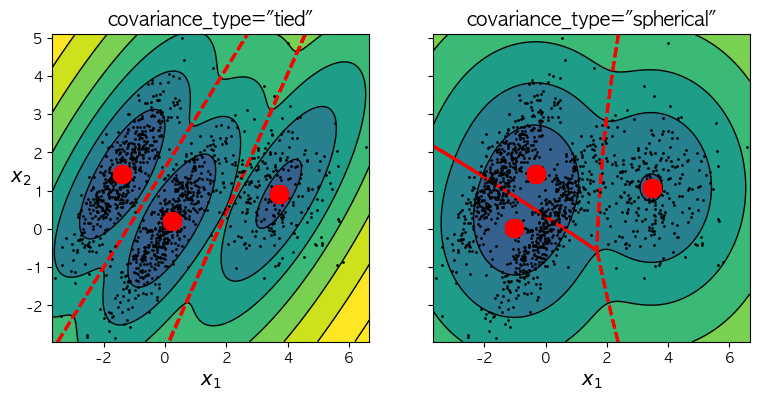

In [121]:
# 추가 코드 - 이 셀은 그림 9-17을 생성하고 저장합니다.

gm_full = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10,
                               covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title(f'covariance_type="{gm1.covariance_type}"')

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title(f'covariance_type="{gm2.covariance_type}"')

compare_gaussian_mixtures(gm_tied, gm_spherical, X)

plt.show()

## Using Gaussian Mixtures for Anomaly Detection
: GMM을 사용하여 밀도가 낮은 지역에 있는 모든 샘플을 이상치로 볼 수 있다. density threshold을 정해야 한다.   
- 이상치 탐지는 데이터셋을 정제하는 데 자주 사용된다.
> ex. 결함있는 제품을 감지하려는 제조사. 제품의 결함 비율은 2%이다.
density threshold를 2%로 하면 밀도가 낮은 지역에 있는 샘플의 2%를 얻을 수 있다.   
>    - 거짓 양성(FP) : 정상인 제품을 불량으로 예측 -> 임계값 낮춤   
>    - 거짓 음성(FN) : 불량인 제품을 정상으로 예측 -> 임계값 높임   
        -> precision(정밀도)/recall(재현율) trade-off
        
⬇︎ 2%를 density threshold로 하여 이상치 구분

In [122]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 2)
anomalies = X[densities < density_threshold]
anomalies

array([[ 0.74219223, -1.00445177],
       [-2.53940854, -2.76549965],
       [-1.74680316, -0.78385111],
       [ 0.53903026,  5.00244257],
       [-0.51480414, -2.16270124],
       [-1.79651788, -0.97031471],
       [-3.39408574, -2.28378778],
       [ 1.58082729,  4.20122873],
       [-2.06317379,  2.2670332 ],
       [-2.54004484, -2.8290338 ],
       [-1.93037427, -1.19447352],
       [-0.27124433, -1.86750177],
       [-1.93315582,  2.49030105],
       [ 5.80546094, -0.85297906],
       [ 5.68060531,  0.20598784],
       [ 3.55103259,  3.47752824],
       [ 5.5515503 ,  2.76962697],
       [ 4.00585006,  4.86701762],
       [ 3.22614554,  3.73445529],
       [ 5.61295857,  2.04675139],
       [ 5.62383575, -0.93780167],
       [ 2.30754386, -1.02494605],
       [ 6.56968319,  2.13386104],
       [ 3.21575068, -1.28763504],
       [ 4.07765947,  3.20474175]])

In [123]:
anomalies.shape

(25, 2)

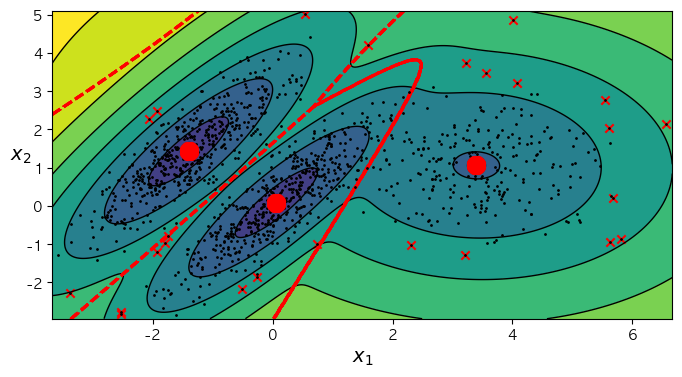

In [132]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='x')
plt.ylim(top=5.1)
plt.show()

## Selecting the Number of Clusters
: k-means 처럼 GaussianMixture 알고리즘은 클러스터의 개수를 지정해야 한다. k-means에서는 inertia나 silhouette score를 사용해 적절한 클러스터 개수를 선택한다. 하지만 이 지표들은 클러스터가 타원형이거나 크기가 다를 때 안정적이지 않기 때문에 GMM에서는 사용할 수 없다. 대신, **BIC(Bayesian information criterion)** 나 **AIC(Akaike information criterion)** 와 같은 **theoretical information criterion(이론적 정보 기준)** 을 최소화하는 모델을 찾는다
> $BIC = log(m)p - 2log(\hat{L})$
> $AIC = 2p - 2log(\hat{L})$
> - m : 샘플 개수
> - p : 모델이 학습할 파라미터 개수
> - $\hat{L}$ : 모델의 likelihood function(가능도 함수)의 최댓값

- BIC와 AIC는 모두 학습할 파라미터가 많은(클러스터가 많은) 모델에 대해서는 패널티를 주고 데이터를 잘 학습하는 모델에 대해서는 보상을 준다.
<!-- Both the BIC and the AIC penalize models that have more parameters to learn (e.g., more clusters) and reward models that fit the data well.  -->
- 둘의 선택은 대부분 비슷한데, 다를 경우 BIC가 선택한 모델이 간단한 경향이 있다. 즉 파라미터가 적은 경향이 있다. 그러나 데이터에 아주 잘 맞지 않을 수 있다. 특히 대규모 데이터셋에서 그렇다.

> Plus, `covariance_type` 파라미터를 `spherical`로 하면 학습할 파라미터 수가 크게 줄어든다. 하지만 데이터에 잘 맞지 않을 수 있다.

In [134]:
print("BIC : ", gm.bic(X).round(2))
print("AIC : ", gm.aic(X).round(2))

BIC :  8189.75
AIC :  8102.52


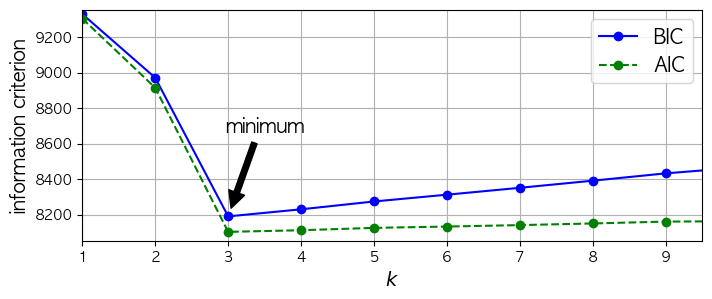

k=3에서 BIC와 AIC 모두 가장 작다. 따라서 k=3이 최선의 선택이다.


In [137]:
# k에 대한 BIC, AIC 변화
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$")
plt.ylabel("information criterion")
plt.axis([1, 9.5, min(aics) - 50, max(aics) + 50])
plt.annotate("", xy=(3, bics[2]), xytext=(3.4, 8650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(3.5, 8660, "minimum", horizontalalignment="center")
plt.legend()
plt.grid()
plt.show()
print("k=3에서 BIC와 AIC 모두 가장 작다. 따라서 k=3이 최선의 선택이다.")

## Bayesian Gaussian Mixture Models
: 최적의 클러스터 개수를 수동으로 찾지 않고 불필요한 클러스터의 가중치를 0으로 만들어 자동으로 제거하는 알고리즘
- `BayesianGaussianMixture` 클래스 사용
    - 현재 문제에 최소한의 정보를 가지고 있다고 가정하고, 생각하는 최적의 클러스터 개수보다 큰 값을 `n_components` 값으로 한다.
    - 이 모델에서는 클러스터 파라미터(가중치, 평균, 공분산 행렬)를 더이상 고정된 모델 파라미터가 아니라 클러스터 할당과 같은 잠재 확률 변수로 취급한다.

In [138]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

In [143]:
bgm.weights_.round(2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

알고리즘이 자동으로 3개의 클러스터만 필요하다고 반환.

In [146]:
bgm.weight_concentration_

(array([494.30375116, 257.01820052, 501.67804585,   1.00000248,
          1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ]),
 array([7.56796249e+02, 5.00778048e+02, 1.00002480e-01, 1.00000000e-01,
        1.00000000e-01, 1.00000000e-01, 1.00000000e-01, 1.00000000e-01,
        1.00000000e-01, 1.00000000e-01]))

## Other Algorithms for Anomaly and Novelty Detection
GMM은 타원형 클러스터에 잘 작동한다. 하지만 다른 모양을 가진 데이터셋에 훈련하면 나쁜 결과를 얻는다. 임의의 모양의 클러스터를 다룰 수 있는 clustering 알고리즘은 다음과 같다.
- PCA and other dimensionality reduction techniques with an `inverse_transform()` method
- Fast-MCD (minimum covariance determinant)
- Isolation forest
- Local outlier factor (LOF)
- One-class SVM